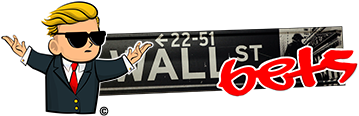

# Common 

## Dependencies

In [ ]:
! pip install PyYAML
! pip install yolov5
! pip install vaderSentiment
! pip install pandas-profiling[notebook] --upgrade
! pip install contractions
! pip install keras-ocr
! pip install CatBoost
! pip install prophet

## Imports

In [ ]:
import pandas as pd
from google.colab import drive
from pandas_profiling import ProfileReport
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
from datetime import date, datetime
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import re
import numpy as np 
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import contractions 
from sklearn.feature_extraction.text import TfidfVectorizer
import pytz
import urllib.request
import glob
import os
import keras_ocr
import time
import torch
import base64
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.feature_selection import *
from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.naive_bayes import *
from sklearn.svm import *
from sklearn.neighbors import *
from sklearn.tree import *
from sklearn.metrics import *
from sklearn.inspection import *

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from prophet import Prophet

import cv2
import pickle 

%matplotlib inline

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
drive.mount('/content/gdrive')
%cd gdrive/My Drive/

## Pre-analysis

### Read data

In [ ]:
def load_df():
  df = pd.read_csv('reddit_wsb_new.csv')
  df = df[["title", "score", "id", "url", "comms_num", "created", "body", "timestamp", "upvote_ratio"]]
  return df

In [ ]:
df = pd.read_csv('reddit_wsb_new.csv')

df = df[["title", "score", "id", "url", "comms_num", "created", "body", "timestamp", "upvote_ratio"]]

df.head(3)

,title,score,id,url,comms_num,created,body,timestamp,upvote_ratio
0,Due to all the manipulation happening on sever...,4,l69fvk,https://www.reddit.com/r/wallstreetbets/commen...,2,1.611768e+09,Many trading platforms have disabled the abili...,Wed Jan 27 18:18:38 2021,0.75
1,Holding GME till the squeeze has squoze. 6421@21,1157,l87ci6,https://i.redd.it/20f2x4ehsce61.png,85,1.611962e+09,NaN,Sat Jan 30 00:12:20 2021,0.99
2,Going long on my dick,0,lc8dnh,https://www.reddit.com/r/wallstreetbets/commen...,7,1.612416e+09,A month ago I found out that I have a big dick...,Thu Feb 4 06:17:59 2021,0.39


## Data preprocessing

In [ ]:
df = load_df()

# Replace NaN body with empty string
df.body.fillna(value="", inplace=True)

df.to_csv('cleaned.csv', index=False) 

df.head(2)

,title,score,id,url,comms_num,created,body,timestamp,upvote_ratio
0,Due to all the manipulation happening on sever...,4,l69fvk,https://www.reddit.com/r/wallstreetbets/commen...,2,1.611768e+09,Many trading platforms have disabled the abili...,Wed Jan 27 18:18:38 2021,0.75
1,Holding GME till the squeeze has squoze. 6421@21,1157,l87ci6,https://i.redd.it/20f2x4ehsce61.png,85,1.611962e+09,,Sat Jan 30 00:12:20 2021,0.99


## Modify timezone

In [ ]:
df = pd.read_csv('cleaned.csv', na_filter=False)

# compare timestamp with created
def timestamp_unix(row):
  return pytz.timezone("Etc/GMT-9").localize(datetime.utcfromtimestamp(int(row.created)))

df["timestamp_unix"] = df.apply(lambda row: timestamp_unix(row), axis=1)

In [ ]:
# sorting by date there's also this one suspicious entry from 2020 that is actually a deleted post
df.sort_values(by=['timestamp_unix'], ascending=True).head(2)


,title,score,id,url,comms_num,created,body,timestamp,upvote_ratio,timestamp_unix
27381,"Daily Discussion Thread for January 19, 2021",604,l0hnrw,https://www.reddit.com/r/wallstreetbets/commen...,23670,1.611054e+09,Your daily trading discussion thread. Please k...,Tue Jan 19 12:00:21 2021,0.92,2021-01-19 11:00:21+09:00
11353,Check out my New Strategy based on Volume,51,l0hqt1,https://www.reddit.com/r/wallstreetbets/commen...,30,1.611054e+09,Hello my fellow retards\n\nAs I already pointe...,Tue Jan 19 12:05:42 2021,0.87,2021-01-19 11:05:42+09:00


In [ ]:
lower_bound = pytz.timezone("Etc/GMT-9").localize(datetime(2021, 1, 20))
upper_bound = pytz.timezone("Etc/GMT-9").localize(datetime(2021, 2, 11))
df[~df["timestamp_unix"].between(lower_bound,upper_bound)].sort_values(by=['timestamp_unix'], ascending=True)

,title,score,id,url,comms_num,created,body,timestamp,upvote_ratio,timestamp_unix
27381,"Daily Discussion Thread for January 19, 2021",604,l0hnrw,https://www.reddit.com/r/wallstreetbets/commen...,23670,1.611054e+09,Your daily trading discussion thread. Please k...,Tue Jan 19 12:00:21 2021,0.92,2021-01-19 11:00:21+09:00
11353,Check out my New Strategy based on Volume,51,l0hqt1,https://www.reddit.com/r/wallstreetbets/commen...,30,1.611054e+09,Hello my fellow retards\n\nAs I already pointe...,Tue Jan 19 12:05:42 2021,0.87,2021-01-19 11:05:42+09:00
2798,For all the autists bored af the past few days...,232,l0hw41,https://www.youtube.com/watch?v=ZEcqHA7dbwM,25,1.611055e+09,,Tue Jan 19 12:16:33 2021,0.99,2021-01-19 11:16:33+09:00
33329,BB vs GME technical analysis,151,l0i42t,https://www.reddit.com/r/wallstreetbets/commen...,70,1.611056e+09,Is BB the next meme stock? From technical poin...,Tue Jan 19 12:32:49 2021,0.85,2021-01-19 11:32:49+09:00
16202,Tendieman v3,3563,l0i84t,https://v.redd.it/po3wsz2b0ac61,141,1.611056e+09,,Tue Jan 19 12:41:18 2021,0.96,2021-01-19 11:41:18+09:00
...,...,...,...,...,...,...,...,...,...,...
26908,"I see a no meme mode, can we get a only meme m...",59,lhh01d,https://www.reddit.com/r/wallstreetbets/commen...,18,1.613035e+09,Omg they don't even have the shitpost flaor an...,Thu Feb 11 10:17:58 2021,0.72,2021-02-11 09:17:58+09:00
25240,While the weed meta continues..,174,lhh7co,https://www.reddit.com/r/wallstreetbets/commen...,141,1.613036e+09,"Guys I have something nice for you, so you mig...",Thu Feb 11 10:32:23 2021,0.73,2021-02-11 09:32:23+09:00
31099,ARCHER (eVTOL) will go public,62,lhhgxm,https://www.reddit.com/r/wallstreetbets/commen...,46,1.613037e+09,This market will blow up by 2025 as soon as th...,Thu Feb 11 10:51:35 2021,0.80,2021-02-11 09:51:35+09:00
28981,Thoughts on $CME - potentially undervalued?,131,lhhgyf,https://www.reddit.com/r/wallstreetbets/commen...,52,1.613037e+09,I was on clubhouse and someone mentioned $CME ...,Thu Feb 11 10:51:37 2021,0.81,2021-02-11 09:51:37+09:00


In [ ]:
df = df[df["timestamp_unix"].between(lower_bound,upper_bound)]
df.head(2)

,title,score,id,url,comms_num,created,body,timestamp,upvote_ratio,timestamp_unix
0,Due to all the manipulation happening on sever...,4,l69fvk,https://www.reddit.com/r/wallstreetbets/commen...,2,1.611768e+09,Many trading platforms have disabled the abili...,Wed Jan 27 18:18:38 2021,0.75,2021-01-27 17:18:38+09:00
1,Holding GME till the squeeze has squoze. 6421@21,1157,l87ci6,https://i.redd.it/20f2x4ehsce61.png,85,1.611962e+09,,Sat Jan 30 00:12:20 2021,0.99,2021-01-29 23:12:20+09:00


In [ ]:
# this example link (index 0 in the df.head)
# https://www.reddit.com/r/wallstreetbets/comments/l6ulcx/its_not_about_the_money_its_about_sending_a/
# shows 12:37:41 for GMT+1 timezone, thus GMT+8 is correct (not the 21:37:41 from the timestamp)

# Drop useless columns
df.drop(columns=['created', 'timestamp'], inplace=True)

df.to_csv('with_changed_timestamp_zone.csv', index=False) 

df.head(2)

# Non visual features

### Date attributes

In [ ]:
df = pd.read_csv('with_changed_timestamp_zone.csv', na_filter=False)

def extract_date_features(row):
    timestamp = row['timestamp_unix']
    d = datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S%z')
    return {'year': d.year, 'month': d.month, 'day': d.day, 'hour': d.hour, 'minute': d.minute, 'day_of_week': d.strftime('%A')}

appiled_df = df.apply(extract_date_features, axis='columns', result_type='expand')
df = pd.concat([df, appiled_df], axis='columns')

df.to_csv('with_date_features.csv', index=False) 

df.head(2)

,title,score,id,url,comms_num,body,upvote_ratio,timestamp_unix,year,month,day,hour,minute,day_of_week
0,Due to all the manipulation happening on sever...,4,l69fvk,https://www.reddit.com/r/wallstreetbets/commen...,2,Many trading platforms have disabled the abili...,0.75,2021-01-27 17:18:38+09:00,2021,1,27,17,18,Wednesday
1,Holding GME till the squeeze has squoze. 6421@21,1157,l87ci6,https://i.redd.it/20f2x4ehsce61.png,85,,0.99,2021-01-29 23:12:20+09:00,2021,1,29,23,12,Friday


### Sentiment attributes

In [ ]:
df = pd.read_csv('with_date_features.csv', na_filter=False)

sia = SentimentIntensityAnalyzer()

def detect_sentiment(content):
    if sia.polarity_scores(content)['compound'] > 0:
        return "Positive"
    elif sia.polarity_scores(content)["compound"] < 0:
        return "Negative"
    else:
        return "Neutral" 

def extract_sentiment_features(row):
    title_sentiment = detect_sentiment(row['title'])
    body_sentiment = detect_sentiment(row['body'])
    return {'title_sentiment': title_sentiment, 'body_sentiment': body_sentiment}

applied_df = df.apply(extract_sentiment_features, axis='columns', result_type='expand')

df = pd.concat([df, applied_df], axis='columns')
df.to_csv('with_sentiment_features.csv', index=False)   

df.head(2)

,title,score,id,url,comms_num,body,upvote_ratio,timestamp_unix,year,month,day,hour,minute,day_of_week,title_sentiment,body_sentiment
0,Due to all the manipulation happening on sever...,4,l69fvk,https://www.reddit.com/r/wallstreetbets/commen...,2,Many trading platforms have disabled the abili...,0.75,2021-01-27 17:18:38+09:00,2021,1,27,17,18,Wednesday,Negative,Positive
1,Holding GME till the squeeze has squoze. 6421@21,1157,l87ci6,https://i.redd.it/20f2x4ehsce61.png,85,,0.99,2021-01-29 23:12:20+09:00,2021,1,29,23,12,Friday,Neutral,Neutral


### Domain attribute

In [ ]:
df = pd.read_csv('with_sentiment_features.csv', na_filter=False)

def extract_domain(row):
    url = row['url']
    domain = urlparse(url).netloc
    return domain

df['domain'] = df.apply(extract_domain, axis='columns')

df.to_csv('with_domain.csv', index=False) 

df.head(2)

,title,score,id,url,comms_num,body,upvote_ratio,timestamp_unix,year,month,day,hour,minute,day_of_week,title_sentiment,body_sentiment,domain
0,Due to all the manipulation happening on sever...,4,l69fvk,https://www.reddit.com/r/wallstreetbets/commen...,2,Many trading platforms have disabled the abili...,0.75,2021-01-27 17:18:38+09:00,2021,1,27,17,18,Wednesday,Negative,Positive,www.reddit.com
1,Holding GME till the squeeze has squoze. 6421@21,1157,l87ci6,https://i.redd.it/20f2x4ehsce61.png,85,,0.99,2021-01-29 23:12:20+09:00,2021,1,29,23,12,Friday,Neutral,Neutral,i.redd.it


### Price attributes

#### Prepare GameStop stock prices

In [ ]:
# create one dataframe by merging the 3 slices obtained from Alpha Vantage API
# presaved into .csv files to not expose my API key
def load_gamestonks():
  gamestonks0 = pd.read_csv("gamestonks0.csv")
  gamestonks1 = pd.read_csv("gamestonks1.csv")
  gamestonks2 = pd.read_csv("gamestonks2.csv")
  return pd.concat([gamestonks0, gamestonks1, gamestonks2])

gamestonks = load_gamestonks()
gamestonks.head(3)

,time,open,high,low,close,volume
0,2021-03-23 20:00:00,155.02,155.38,154.03,154.0300,9035
1,2021-03-23 19:59:00,155.50,155.50,155.00,155.2899,5919
2,2021-03-23 19:58:00,155.03,155.90,155.01,155.5000,5817


In [ ]:
# Change to the same timezone as reddit
# Alpha Vantage always uses Eastern/US timezone (GMT-4 at the time)
tz_old = pytz.timezone('Etc/GMT+4')
# -8 is +8 viva python
tz_new = pytz.timezone("Etc/GMT-8")
# date format
format = '%Y-%m-%d %H:%M:%S'

def change_timezone(row):
  row.time = tz_old.localize(datetime.strptime(row.time, format)).astimezone(tz_new)
  return row

gamestonks = gamestonks.apply(change_timezone, axis=1)

gamestonks.to_csv('gamestonks.csv', index=False) 

gamestonks.head(2)

,time,open,high,low,close,volume
0,2021-03-24 08:00:00+08:00,155.02,155.38,154.03,154.0300,9035
1,2021-03-24 07:59:00+08:00,155.50,155.50,155.00,155.2899,5919


In [ ]:
# Set time as index
gamestonks = pd.read_csv('gamestonks.csv', na_filter=False)

gamestonks['time'] = gamestonks['time'].astype('datetime64')
gamestonks = gamestonks.set_index("time")
gamestonks.head(3)

,open,high,low,close,volume
time,,,,,
2021-03-24 00:00:00,155.02,155.38,154.03,154.0300,9035
2021-03-23 23:59:00,155.50,155.50,155.00,155.2899,5919
2021-03-23 23:58:00,155.03,155.90,155.01,155.5000,5817


In [ ]:
df = pd.read_csv('with_domain.csv', na_filter=False)

df['timestamp_unix_utc'] = df['timestamp_unix'].astype('datetime64')

def gamestop_price(row):
  # dt = pytz.timezone("Etc/GMT-8").localize(datetime.utcfromtimestamp(int(row.created)))
  loc = gamestonks.index.get_loc(row.timestamp_unix_utc, method='nearest')

  if gamestonks.shape[0] > loc+1:
    loc = loc+1
  else:
    print(f'Faulty loc: {loc}')
    print('For row:')
    print(row)
  return gamestonks.iloc[loc].close

df['gamestop_price'] = df.apply(lambda row: gamestop_price(row), axis=1)

df.drop(columns=['timestamp_unix_utc'], inplace=True)

df.to_csv('with_gamestop_price.csv', index=False) 

df.head(2)

,title,score,id,url,comms_num,body,upvote_ratio,timestamp_unix,year,month,day,hour,minute,day_of_week,title_sentiment,body_sentiment,domain,gamestop_price
0,Due to all the manipulation happening on sever...,4,l69fvk,https://www.reddit.com/r/wallstreetbets/commen...,2,Many trading platforms have disabled the abili...,0.75,2021-01-27 17:18:38+09:00,2021,1,27,17,18,Wednesday,Negative,Positive,www.reddit.com,244.0
1,Holding GME till the squeeze has squoze. 6421@21,1157,l87ci6,https://i.redd.it/20f2x4ehsce61.png,85,,0.99,2021-01-29 23:12:20+09:00,2021,1,29,23,12,Friday,Neutral,Neutral,i.redd.it,318.0


### Text attributes

In [ ]:
EMOJII_REGEX = re.compile(r"[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]")
HASHTAG_REGEX = re.compile(r"#\w+")
URL_REGEX = re.compile(r"""\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))""")
WORDS_SPACE_REGEX = re.compile(r'[^\w\s]')

In [ ]:
df = pd.read_csv('with_gamestop_price.csv', na_filter=False)

df['title_chars_number'] = df['title'].str.len()
df['body_chars_number'] = df['body'].str.len()

df['title_words_number'] = df['title'].str.split().str.len()
df['body_words_number'] = df['body'].str.split().str.len()

df['title_chars_per_word'] = df['title_chars_number'].div(df['title_words_number']).replace(np.nan, 0)
df['body_chars_per_word'] = df['body_chars_number'].div(df['body_words_number']).replace(np.nan, 0)

df['title_numbers_number'] = df['title'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
df['body_numbers_number'] = df['body'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

df['body_hashtags_number'] = df['body'].apply(lambda x: len(HASHTAG_REGEX.findall(x)))
df['body_links_number'] = df['body'].apply(lambda x: len(URL_REGEX.findall(x)))
df['title_emoji_number'] = df['title'].apply(lambda x: len(EMOJII_REGEX.findall(x)))
df['body_emoji_number'] = df['body'].apply(lambda x: len(EMOJII_REGEX.findall(x)))

df.to_csv('with_text_attributes.csv', index=False) 

df.head(2)


,title,score,id,url,comms_num,body,upvote_ratio,timestamp_unix,year,month,day,hour,minute,day_of_week,title_sentiment,body_sentiment,domain,gamestop_price,title_chars_number,body_chars_number,title_words_number,body_words_number,title_chars_per_word,body_chars_per_word,title_numbers_number,body_numbers_number,body_hashtags_number,body_links_number,title_emoji_number,body_emoji_number
0,Due to all the manipulation happening on sever...,4,l69fvk,https://www.reddit.com/r/wallstreetbets/commen...,2,Many trading platforms have disabled the abili...,0.75,2021-01-27 17:18:38+09:00,2021,1,27,17,18,Wednesday,Negative,Positive,www.reddit.com,244.0,114,162,17,25,6.705882,6.48,0,0,0,0,0,0
1,Holding GME till the squeeze has squoze. 6421@21,1157,l87ci6,https://i.redd.it/20f2x4ehsce61.png,85,,0.99,2021-01-29 23:12:20+09:00,2021,1,29,23,12,Friday,Neutral,Neutral,i.redd.it,318.0,48,0,8,0,6.000000,0.00,0,0,0,0,0,0


### Text frequency attributes

In [ ]:
stop = stopwords.words('english')
stemmer = PorterStemmer()

def preproces_text(text):
    text = contractions.fix(text)
    text = WORDS_SPACE_REGEX.sub("", text)
    text = " ".join(x for x in text.split() if x not in stop)
    text = text.lower()
    text = " ".join([stemmer.stem(word) for word in text.split()])
    return text

def preproces_emoji(text):
    text = " ".join(EMOJII_REGEX.findall(text))
    return text

In [ ]:
df = pd.read_csv('with_text_attributes.csv', na_filter=False)

def preproces_text_features(row):
    processed_title = preproces_text(row['title'])
    processed_body = preproces_text(row['body'])
    processed_emoji = preproces_emoji(f"{row['title']} {row['body']}")
    return {'processed_title': processed_title, 'processed_body': processed_body, 'processed_emoji': processed_emoji}

applied_df = df.apply(preproces_text_features, axis='columns', result_type='expand')

df = pd.concat([df, applied_df], axis='columns')

df.drop(columns=['title', 'body'], inplace=True)

df.to_csv('with_preprocessed_text.csv', index=False) 

df.head(2)

,score,id,url,comms_num,upvote_ratio,timestamp_unix,year,month,day,hour,minute,day_of_week,title_sentiment,body_sentiment,domain,gamestop_price,title_chars_number,body_chars_number,title_words_number,body_words_number,title_chars_per_word,body_chars_per_word,title_numbers_number,body_numbers_number,body_hashtags_number,body_links_number,title_emoji_number,body_emoji_number,processed_title,processed_body,processed_emoji
0,4,l69fvk,https://www.reddit.com/r/wallstreetbets/commen...,2,0.75,2021-01-27 17:18:38+09:00,2021,1,27,17,18,Wednesday,Negative,Positive,www.reddit.com,244.0,114,162,17,25,6.705882,6.48,0,0,0,0,0,0,due manipul happen sever differ platform someo...,mani trade platform disabl abil buy sell gme s...,
1,1157,l87ci6,https://i.redd.it/20f2x4ehsce61.png,85,0.99,2021-01-29 23:12:20+09:00,2021,1,29,23,12,Friday,Neutral,Neutral,i.redd.it,318.0,48,0,8,0,6.000000,0.00,0,0,0,0,0,0,hold gme till squeez squoz 642121,,


In [ ]:
df = pd.read_csv('with_preprocessed_text.csv', na_filter=False)

model = TfidfVectorizer(max_features=25, lowercase=True, analyzer='word', stop_words= 'english',ngram_range=(1,1))

tf_idf = model.fit_transform(df['processed_title'])

tf_idf_df = pd.DataFrame(tf_idf.toarray(), columns=model.get_feature_names())
tf_idf_df = tf_idf_df.add_prefix('title_')

df = pd.concat([df, tf_idf_df], axis='columns')

df.to_csv('with_title_tf_idf.csv', index=False) 

df.head(2)

,score,id,url,comms_num,upvote_ratio,timestamp_unix,year,month,day,hour,minute,day_of_week,title_sentiment,body_sentiment,domain,gamestop_price,title_chars_number,body_chars_number,title_words_number,body_words_number,title_chars_per_word,body_chars_per_word,title_numbers_number,body_numbers_number,body_hashtags_number,body_links_number,title_emoji_number,body_emoji_number,processed_title,processed_body,processed_emoji,title_amc,title_bb,title_bought,title_buy,title_dip,title_fuck,title_gme,title_guy,title_hold,title_let,title_like,title_market,title_moon,title_nok,title_retard,title_robinhood,title_sell,title_share,title_short,title_stock,title_stop,title_thi,title_time,title_today,title_trade
0,4,l69fvk,https://www.reddit.com/r/wallstreetbets/commen...,2,0.75,2021-01-27 17:18:38+09:00,2021,1,27,17,18,Wednesday,Negative,Positive,www.reddit.com,244.0,114,162,17,25,6.705882,6.48,0,0,0,0,0,0,due manipul happen sever differ platform someo...,mani trade platform disabl abil buy sell gme s...,,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1157,l87ci6,https://i.redd.it/20f2x4ehsce61.png,85,0.99,2021-01-29 23:12:20+09:00,2021,1,29,23,12,Friday,Neutral,Neutral,i.redd.it,318.0,48,0,8,0,6.000000,0.00,0,0,0,0,0,0,hold gme till squeez squoz 642121,,,0.0,0.0,0.0,0.0,0.0,0.0,0.62633,0.0,0.779558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df = pd.read_csv('with_title_tf_idf.csv', na_filter=False)

model = TfidfVectorizer(max_features=25, lowercase=True, analyzer='word', stop_words= 'english',ngram_range=(1,1))

tf_idf = model.fit_transform(df['processed_body'])

tf_idf_df = pd.DataFrame(tf_idf.toarray(), columns=model.get_feature_names())
tf_idf_df = tf_idf_df.add_prefix('body_')

df = pd.concat([df, tf_idf_df], axis='columns')

df.to_csv('with_body_tf_idf.csv', index=False) 

df.head(2)

,score,id,url,comms_num,upvote_ratio,timestamp_unix,year,month,day,hour,minute,day_of_week,title_sentiment,body_sentiment,domain,gamestop_price,title_chars_number,body_chars_number,title_words_number,body_words_number,title_chars_per_word,body_chars_per_word,title_numbers_number,body_numbers_number,body_hashtags_number,body_links_number,title_emoji_number,body_emoji_number,processed_title,processed_body,processed_emoji,title_amc,title_bb,title_bought,title_buy,title_dip,title_fuck,title_gme,title_guy,title_hold,...,title_like,title_market,title_moon,title_nok,title_retard,title_robinhood,title_sell,title_share,title_short,title_stock,title_stop,title_thi,title_time,title_today,title_trade,body_amc,body_buy,body_compani,body_day,body_fuck,body_fund,body_gme,body_hold,body_know,body_like,body_make,body_market,body_money,body_peopl,body_price,body_robinhood,body_sell,body_share,body_short,body_stock,body_thi,body_think,body_time,body_trade,body_want
0,4,l69fvk,https://www.reddit.com/r/wallstreetbets/commen...,2,0.75,2021-01-27 17:18:38+09:00,2021,1,27,17,18,Wednesday,Negative,Positive,www.reddit.com,244.0,114,162,17,25,6.705882,6.48,0,0,0,0,0,0,due manipul happen sever differ platform someo...,mani trade platform disabl abil buy sell gme s...,,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.407173,0.0,0.0,0.0,0.0,0.38988,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.476174,0.462825,0.0,0.0,0.0,0.0,0.0,0.491178,0.0
1,1157,l87ci6,https://i.redd.it/20f2x4ehsce61.png,85,0.99,2021-01-29 23:12:20+09:00,2021,1,29,23,12,Friday,Neutral,Neutral,i.redd.it,318.0,48,0,8,0,6.000000,0.00,0,0,0,0,0,0,hold gme till squeez squoz 642121,,,0.0,0.0,0.0,0.0,0.0,0.0,0.62633,0.0,0.779558,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [ ]:
df = pd.read_csv('with_body_tf_idf.csv', na_filter=False)

model = TfidfVectorizer(max_features=10, token_pattern=r'[^\s]+' ,ngram_range=(1,1))

tf_idf = model.fit_transform(df['processed_emoji'])

tf_idf_df = pd.DataFrame(tf_idf.toarray(), columns=model.get_feature_names())
tf_idf_df = tf_idf_df.add_prefix('emoji_')

df = pd.concat([df, tf_idf_df], axis='columns')

df.to_csv('with_emoji_tf_idf.csv', index=False)

df.head(2)

,score,id,url,comms_num,upvote_ratio,timestamp_unix,year,month,day,hour,minute,day_of_week,title_sentiment,body_sentiment,domain,gamestop_price,title_chars_number,body_chars_number,title_words_number,body_words_number,title_chars_per_word,body_chars_per_word,title_numbers_number,body_numbers_number,body_hashtags_number,body_links_number,title_emoji_number,body_emoji_number,processed_title,processed_body,processed_emoji,title_amc,title_bb,title_bought,title_buy,title_dip,title_fuck,title_gme,title_guy,title_hold,...,title_stop,title_thi,title_time,title_today,title_trade,body_amc,body_buy,body_compani,body_day,body_fuck,body_fund,body_gme,body_hold,body_know,body_like,body_make,body_market,body_money,body_peopl,body_price,body_robinhood,body_sell,body_share,body_short,body_stock,body_thi,body_think,body_time,body_trade,body_want,emoji_🌕,emoji_🌙,emoji_🏻,emoji_🏼,emoji_👐,emoji_💎,emoji_📈,emoji_🔥,emoji_🙌,emoji_🚀
0,4,l69fvk,https://www.reddit.com/r/wallstreetbets/commen...,2,0.75,2021-01-27 17:18:38+09:00,2021,1,27,17,18,Wednesday,Negative,Positive,www.reddit.com,244.0,114,162,17,25,6.705882,6.48,0,0,0,0,0,0,due manipul happen sever differ platform someo...,mani trade platform disabl abil buy sell gme s...,,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.407173,0.0,0.0,0.0,0.0,0.38988,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.476174,0.462825,0.0,0.0,0.0,0.0,0.0,0.491178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1157,l87ci6,https://i.redd.it/20f2x4ehsce61.png,85,0.99,2021-01-29 23:12:20+09:00,2021,1,29,23,12,Friday,Neutral,Neutral,i.redd.it,318.0,48,0,8,0,6.000000,0.00,0,0,0,0,0,0,hold gme till squeez squoz 642121,,,0.0,0.0,0.0,0.0,0.0,0.0,0.62633,0.0,0.779558,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Type of post

In [ ]:
df = pd.read_csv('with_emoji_tf_idf.csv', na_filter=False)

def extract_type(row):
    domain = row['domain']
    
    if domain == 'i.redd.it':
      type = 'image'
    elif domain == 'v.redd.it':
      type = 'video'
    elif domain == 'www.reddit.com':
      type = 'self'
    else:
      type = 'other'
    return type

df['type'] = df.apply(extract_type, axis='columns')

df.to_csv('with_post_type.csv', index=False) 

df.head(2)

,score,id,url,comms_num,upvote_ratio,timestamp_unix,year,month,day,hour,minute,day_of_week,title_sentiment,body_sentiment,domain,gamestop_price,title_chars_number,body_chars_number,title_words_number,body_words_number,title_chars_per_word,body_chars_per_word,title_numbers_number,body_numbers_number,body_hashtags_number,body_links_number,title_emoji_number,body_emoji_number,processed_title,processed_body,processed_emoji,title_amc,title_bb,title_bought,title_buy,title_dip,title_fuck,title_gme,title_guy,title_hold,...,title_thi,title_time,title_today,title_trade,body_amc,body_buy,body_compani,body_day,body_fuck,body_fund,body_gme,body_hold,body_know,body_like,body_make,body_market,body_money,body_peopl,body_price,body_robinhood,body_sell,body_share,body_short,body_stock,body_thi,body_think,body_time,body_trade,body_want,emoji_🌕,emoji_🌙,emoji_🏻,emoji_🏼,emoji_👐,emoji_💎,emoji_📈,emoji_🔥,emoji_🙌,emoji_🚀,type
0,4,l69fvk,https://www.reddit.com/r/wallstreetbets/commen...,2,0.75,2021-01-27 17:18:38+09:00,2021,1,27,17,18,Wednesday,Negative,Positive,www.reddit.com,244.0,114,162,17,25,6.705882,6.48,0,0,0,0,0,0,due manipul happen sever differ platform someo...,mani trade platform disabl abil buy sell gme s...,,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.407173,0.0,0.0,0.0,0.0,0.38988,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.476174,0.462825,0.0,0.0,0.0,0.0,0.0,0.491178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,self
1,1157,l87ci6,https://i.redd.it/20f2x4ehsce61.png,85,0.99,2021-01-29 23:12:20+09:00,2021,1,29,23,12,Friday,Neutral,Neutral,i.redd.it,318.0,48,0,8,0,6.000000,0.00,0,0,0,0,0,0,hold gme till squeez squoz 642121,,,0.0,0.0,0.0,0.0,0.0,0.0,0.62633,0.0,0.779558,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,image


## Post-analysis

In [ ]:
df = pd.read_csv('with_post_type.csv', na_filter=False)

In [ ]:
ProfileReport(df, minimal=True)

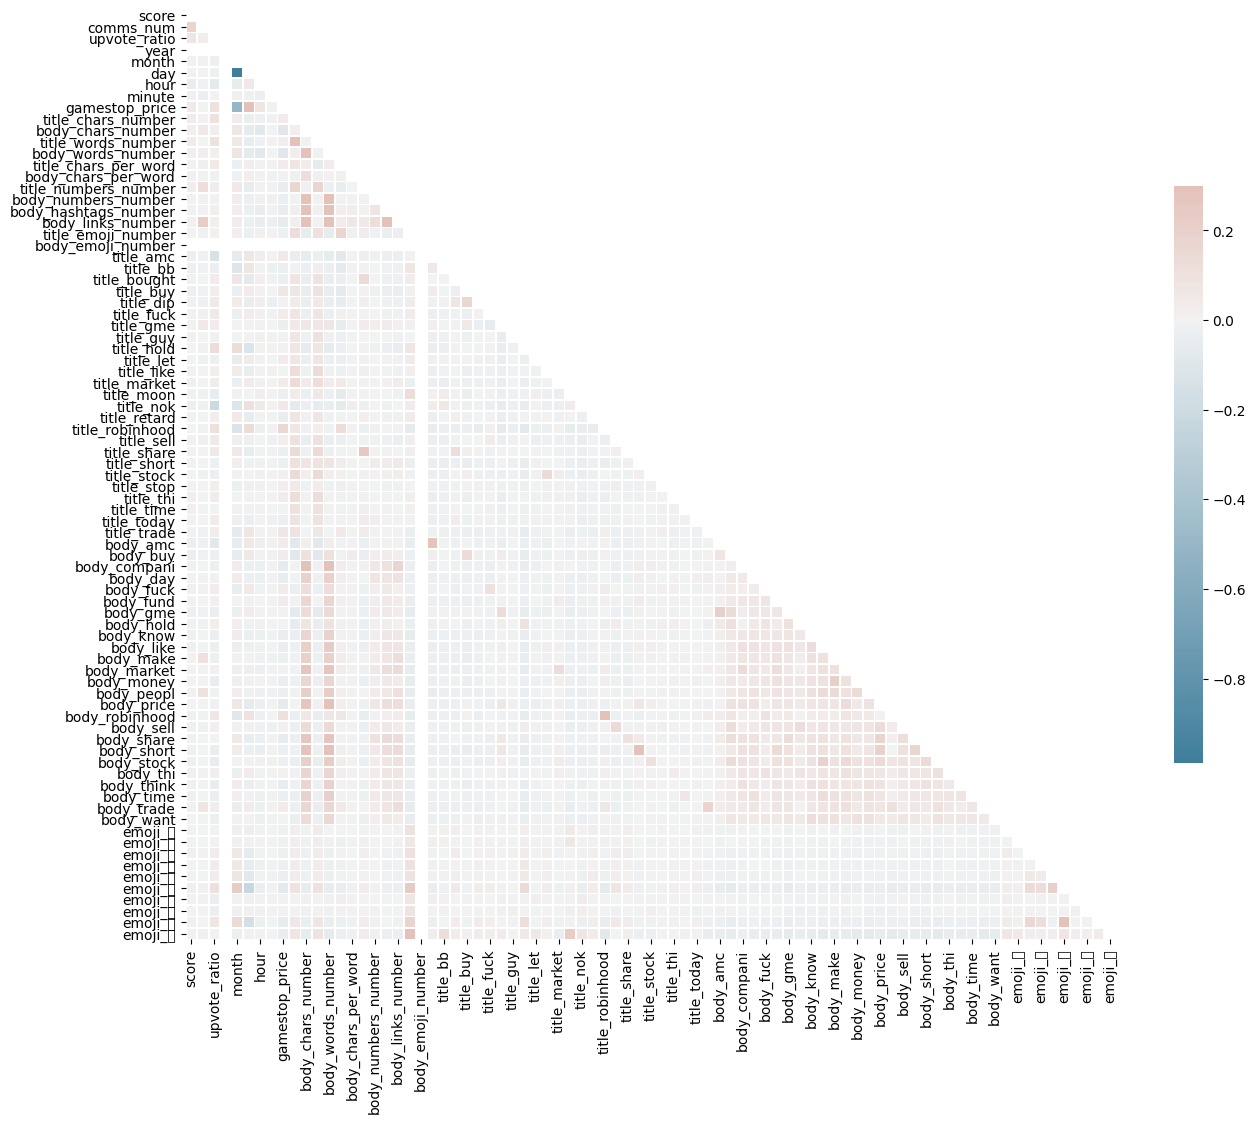

In [ ]:
import warnings
warnings.filterwarnings("ignore")

corr = df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(15, 15))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})